In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
import analyze_utils

save_dir = '/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels_rerun'

r, all_losses = analyze_utils.load_results_and_cache_autoprompt_json(
    save_dir, include_losses=True, do_reranking=True, save_file='r.pkl')

getting dir_names...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 73.49it/s]


In [3]:
min([len(L) for L in all_losses])

62

In [4]:
top_prompts = (
    r.groupby(['task_name', 'seed', 'max_digit'])
).first().reset_index()
top_prompts[['task_name', 'seed', 'max_digit', 'prefixes', 'reciprocal_rank']]

,task_name,seed,max_digit,prefixes,reciprocal_rank
0,add_two,1,10,Add two integers together to arrive,1.000000
1,add_two,1,40,Add two positive integers together to,1.000000
2,add_two,1,80,Add two integers together to get,1.000000
3,add_two,1,160,Add two integers together to get,1.000000
4,add_two,2,10,Write a function to add together,1.000000
...,...,...,...,...,...
67,subtract_two,2,40,What number can you subtract from,1.000000
68,subtract_two,2,80,The next number in a series,0.076923
69,subtract_two,2,160,How do you subtract a number,1.000000
70,subtract_two,3,10,Use your function to compute each,0.055556


<AxesSubplot:ylabel='max_digit'>

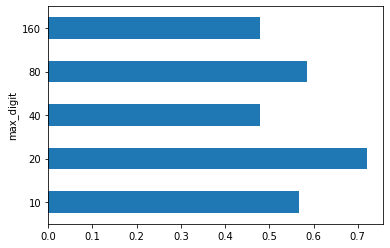

In [5]:
top_prompts.groupby('max_digit').mean()['reciprocal_rank'].plot(kind='barh')

In [6]:
top_prompts['reciprocal_rank'].mean()

0.5636972341906694

In [7]:
assert r['checkpoint'].unique()[0] == "EleutherAI/gpt-j-6B"

In [8]:
from iprompt import prompt_classification

model = prompt_classification.create_model(r['checkpoint'].unique()[0])

2023-01-23 16:36:40.303789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 16:36:40.479486: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-23 16:36:40.518068: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-23 16:36:41.508359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
## Compute accuracy given correct prompt and save for each task.
import argparse
from tqdm.notebook import tqdm
from iprompt.data import get_data


data = []
print('calculating accs...')
n_shots = 1
batch_size = 16

"""
task_name: str = 'add_two',
 n_shots: int = 1,
 train_split_frac: float = None,
 max_dset_size: int = 10000,
 template_num_task_phrasing: int = 0,
 max_digit: int = 10,
 """

for _, output in tqdm(top_prompts.iterrows(), total=len(top_prompts)):
    args = argparse.Namespace(**output)
    args.max_dset_size = 100
    (dset, dset_test), check_answer_func, descr = get_data(
        args.task_name, n_shots=1, train_split_frac=1.0,
        max_dset_size=args.max_dset_size, template_num_task_phrasing=0,
        max_digit=args.max_digit,
    )
    print(args.task_name, f'dset of len {len(dset)} (max_digit={args.max_digit})')
    # if task_name == 'task107_splash_question_to_sql':
    #     batch_size = max(1, batch_size//4)
    ####   Manual prompt  ####
    manual_loss, manual_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=descr, multi_token=True, verbose=False,
        batch_size=batch_size,
    )
    print(f'>\tmanual acc: {manual_acc}')
    ####   iPrompt prompt   ####
    iprompt_loss, iprompt_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=output['prefixes'], multi_token=True, verbose=False,
        batch_size=batch_size,
    )
    print(f'>\tiprompt acc: {iprompt_acc}')
    ####
    output['manual_loss'] = manual_loss
    output['manual_acc'] = manual_acc
    output['iprompt_loss'] = iprompt_loss
    output['iprompt_acc'] = iprompt_acc
    data.append(output)

calculating accs...


  0%|          | 0/72 [00:00<?, ?it/s]

add_two dset of len 100 (max_digit=10)
>	manual acc: 74.0
>	iprompt acc: 79.0
add_two dset of len 100 (max_digit=40)
>	manual acc: 55.0
>	iprompt acc: 62.0
add_two dset of len 100 (max_digit=80)
>	manual acc: 45.0
>	iprompt acc: 55.0
add_two dset of len 100 (max_digit=160)
>	manual acc: 29.0
>	iprompt acc: 24.0
add_two dset of len 100 (max_digit=10)
>	manual acc: 74.0
>	iprompt acc: 89.0
add_two dset of len 100 (max_digit=80)


In [ ]:
len(top_prompts), len(top_prompts_df)

In [ ]:
import os

top_prompts_df = pd.DataFrame(data)
top_prompts_df.to_pickle(os.path.join(save_dir, 'top_prompts.pkl'))
# top_prompts_df = pd.read_pickle(os.path.join(save_dir, 'top_prompts.pkl'))

In [ ]:
top_prompts_df['prompt_ratio'] = top_prompts_df['manual_acc'] / top_prompts_df['iprompt_acc']

In [ ]:
top_prompts_df[['prefixes', 'iprompt_acc', 'manual_acc']]

In [ ]:
top_prompts_df[top_prompts_df['task_name'].map(lambda tn: (('first' in tn) or ('double' in tn)))][['task_name', 'prefixes', 'reciprocal_rank', 'max_digit', 'iprompt_acc', 'manual_acc']]

In [ ]:
import seaborn as sns
task_acc_percent = ((
            top_prompts_df.groupby(['task_name']).mean()
        ) 
        / 
        (1 
            # top_prompts_df.groupby(['task_name']).max()['manual_acc'] - top_prompts_df.groupby(['task_name']).min()['manual_acc']
        )
).reset_index()

# task_acc_percent = task_acc_percent[
#     task_acc_percent['task_name'].map(lambda s: s not in [''])
# ]

df = task_acc_percent

ax = sns.scatterplot(data=df, x='reciprocal_rank', y='manual_acc', label='Manual')
for i in range(len(task_acc_percent)):
    txt, y, x = (
        df.iloc[i]["task_name"],
        df.iloc[i]["manual_acc"],
        df.iloc[i]["reciprocal_rank"]
    )
    ax.annotate(txt, (x, y), fontsize=8, weight="normal", alpha=0.9, family="monospace")

In [ ]:
import seaborn as sns
task_acc_percent = ((
            top_prompts_df.groupby(['max_digit']).mean()
        ) 
        / 
        (1 
            # top_prompts_df.groupby(['task_name']).max()['manual_acc'] - top_prompts_df.groupby(['task_name']).min()['manual_acc']
        )
).reset_index()

# task_acc_percent = task_acc_percent[
#     task_acc_percent['task_name'].map(lambda s: s not in [''])
# ]

sns.lineplot(data=task_acc_percent, x='max_digit', y='manual_acc', linewidth=4, label='Manual')
sns.lineplot(data=task_acc_percent, x='max_digit', y='iprompt_acc', linewidth=4, color='red', label='iPrompt')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

r_grouped_by_task = (
    top_prompts_df
     .groupby(['max_digit']).mean()
     .reset_index()
)

ax = sns.scatterplot(
    data=top_prompts_df, x='manual_acc', y='reciprocal_rank', # hue='task_name',
)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # legend outside of plot
# ax.set_yscale('log')

In [ ]:
top_prompts[top_prompts['reciprocal_rank'] > 0.1][['prefixes','reciprocal_rank','task_name']]

## Plot losses

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


plt.plot(np.array(all_losses[20]))